In [1]:
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Ellipse

import matplotlib as mpl
import seaborn as sns

# Set up some parameters for pretty plots
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [121]:


# Define the line
a, b = -1, 2  # changed the slope a to -1
N = 10
X = np.linspace(0, 10, N)
Y = a * X + b
covs = []

# Add 2D Gaussian noise to each point with random covariance matrix
for i in range(N):
    r = np.random.randn(2, 2)*0.8
    cov = np.dot(r, r.transpose())
    covs.append(cov)

    noise = np.random.multivariate_normal([0, 0], cov)
    X[i] += noise[0]
    Y[i] += noise[1]

# Create a grid of points
X_line = np.linspace(np.min(X) - 10, np.max(X) + 10, 100)  # Adjust the offset according to your needs
Y_line = np.linspace(np.min(Y) - 10, np.max(Y) + 10, 100)  # Adjust the offset according to your needs


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [122]:
def ortho_error(params):
    m, c = params
    num = np.abs(m*X - Y + c)
    den = np.sqrt(m**2 + 1)
    dists = num / den
    return np.sum(dists**2)

# Fit the line by minimizing the sum of square errors in the y direction
A = np.vstack([X, np.ones(len(X))]).T
m_y_noerr, c_y_noerr = np.linalg.lstsq(A, Y, rcond=None)[0]

# Fit the line by minimizing the sum of square errors in the x direction
A = np.vstack([Y, np.ones(len(Y))]).T
m_x_noerr, c_x_noerr = np.linalg.lstsq(A, X, rcond=None)[0]

# Fit the line by minimizing the sum of squares of orthogonal distances
init_params = [-1.1, 2.1]  # Initial guess for parameters
res = minimize(ortho_error, init_params, method='BFGS')
m_ortho_noerr, c_ortho_noerr = res.x


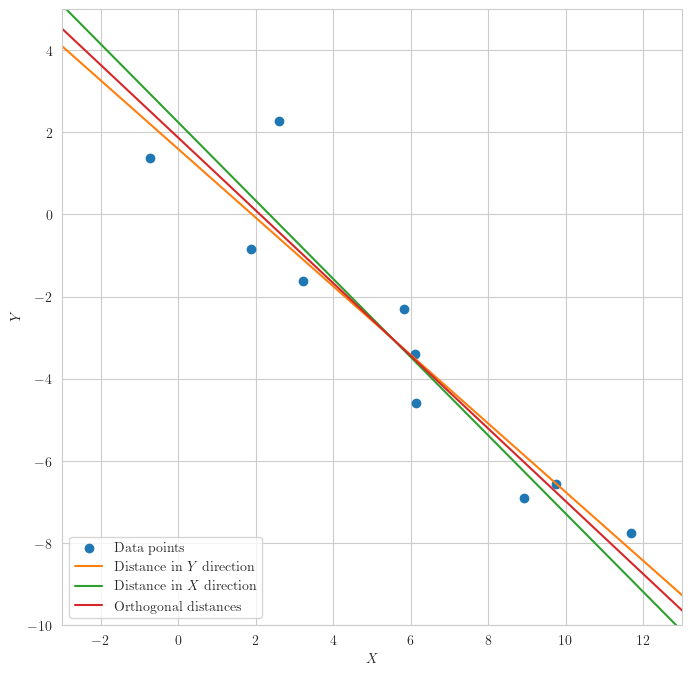

In [127]:
plt.figure(figsize=(8, 8))

# Scatter plot of the data
plt.scatter(X, Y, label='Data points', color='tab:blue')

# Line plots for the three different models
plt.plot(X_line, m_y_noerr*X_line + c_y_noerr, color='tab:orange', label='Distance in $Y$ direction')
plt.plot(m_x_noerr*Y_line + c_x_noerr, Y_line, color='tab:green', label='Distance in $X$ direction')
plt.plot(X_line, m_ortho_noerr*X_line + c_ortho_noerr, color='tab:red', label='Orthogonal distances')

# Add a legend
plt.legend(loc='lower left')

# Add labels and set limits
plt.xlim(-3,13)
plt.ylim(-10, 5)

plt.xlabel('$X$')
plt.ylabel('$Y$')

plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/linear_regression_noerr.png',dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


In [124]:
# Define function to calculate weighted sum of square errors in y direction
def weighted_y_error(params):
    m, c = params
    errors = (Y - m*X - c) ** 2
    return np.sum(errors / np.array([cov[1, 1] for cov in covs]))

# Define function to calculate weighted sum of square errors in x direction
def weighted_x_error(params):
    m, c = params
    errors = (X - m*Y - c) ** 2
    return np.sum(errors / np.array([cov[0, 0] for cov in covs]))

def mahalanobis_error(params):
    m, c = params
    dists = []
    for x, y, cov in zip(X, Y, covs):
        # Define the line vector
        line_vector = np.array([m, -1])
        
        # Calculate the Mahalanobis distance from the point to the line
        numerator = (m*x - y + c)**2
        denominator = np.dot(line_vector.T, np.dot(cov, line_vector))
        dist = numerator / denominator
        dists.append(dist)

    return np.sum(dists)

# Fit the line by minimizing the weighted sum of square errors in the y direction
init_params = [-1.1, 2.1]  # Initial guess for parameters
res = minimize(weighted_y_error, init_params, method='BFGS')
m_y, c_y = res.x

# Fit the line by minimizing the weighted sum of square errors in the x direction
res = minimize(weighted_x_error, init_params, method='BFGS')
m_x, c_x = res.x

# Fit the line by minimizing the sum of Mahalanobis distances to the line
res = minimize(mahalanobis_error, init_params, method='BFGS')
m_mahalanobis, c_mahalanobis = res.x


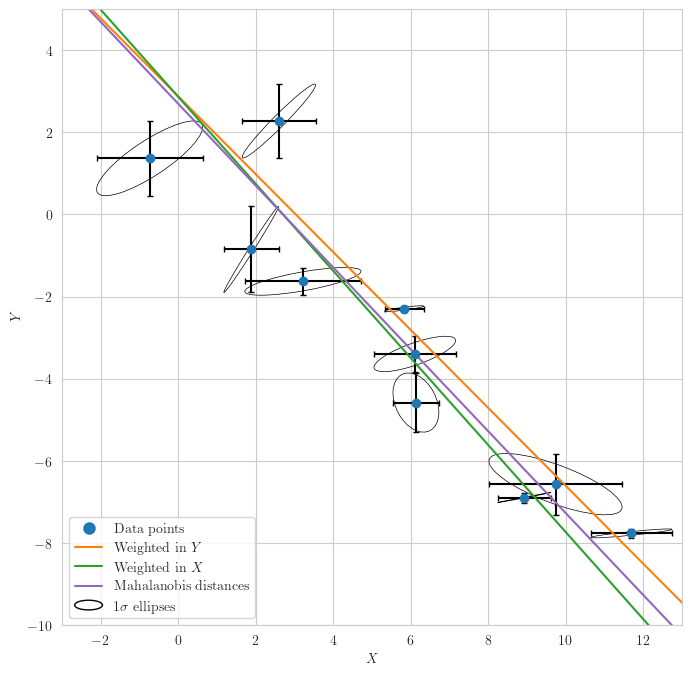

In [126]:
# Add a custom legend entry for the ellipses
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


N = len(X)

fig, ax = plt.subplots(figsize=(8, 8))

# Define the lines
X_line = np.linspace(np.min(X) - 10, np.max(X) + 10, 100)  # Adjust the offset according to your needs
Y_line = np.linspace(np.min(Y) - 10, np.max(Y) + 10, 100)  # Adjust the offset according to your needs

# Add 2D error bars for each point and the lines
for i in range(N):
    ax.errorbar(X[i], Y[i], xerr=np.sqrt(covs[i][0,0]), yerr=np.sqrt(covs[i][1,1]), fmt='o', color='tab:blue', ecolor='black', capsize=2)

# Plot the lines
ax.plot(X_line, m_y*X_line + c_y, color='tab:orange', label='Weighted in $Y$')
ax.plot(m_x*Y_line + c_x, Y_line, color='tab:green', label='Weighted in $X$')
ax.plot(X_line, m_mahalanobis*X_line + c_mahalanobis, color='tab:purple', label='Mahalanobis distances')

# Add 1-sigma ellipse for each point
for i in range(N):
    lambda_, v = np.linalg.eig(covs[i])
    lambda_ = np.sqrt(lambda_)
    angle = np.rad2deg(np.arctan2(v[1, 0], v[0, 0]))  # compute the angle
    ell = Ellipse(xy=(X[i], Y[i]),
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=angle,  # use the computed angle
                  edgecolor='black', fc='None', lw=0.5)
    ax.add_patch(ell)

# Create an empty ellipse patch
empty_ellipse = mpatches.Ellipse((0, 0), 1, 1, edgecolor='black', facecolor='none')

# Create the legend objects
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10),
                   plt.Line2D([0], [0], color='tab:orange'),
                   plt.Line2D([0], [0], color='tab:green'),
                   plt.Line2D([0], [0], color='tab:purple'),
                   empty_ellipse]

# legend_elements = [plt.errorbar([0], [0], xerr=0.1, yerr=0.2, fmt='o', color='w', markerfacecolor='tab:blue', markersize=10, capsize=2),
#                    plt.Line2D([0], [0], color='tab:orange'),
#                    plt.Line2D([0], [0], color='tab:green'),
#                    plt.Line2D([0], [0], color='tab:purple'),
#                    Ellipse((0, 0), 1, 1, edgecolor='black', facecolor='none')]


# Create the legend labels
legend_labels = ['Data points', 'Weighted in $Y$', 'Weighted in $X$', 'Mahalanobis distances', '1$\sigma$ ellipses']

# Add the legend
ax.legend(legend_elements, legend_labels, handler_map={mpatches.Ellipse: HandlerEllipse()}, loc='lower left')

# Set labels and limits
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_xlim(-3,13)
ax.set_ylim(-10, 5)


plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/weighted_regression.png',dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
